## Setup

In [1]:
from osdatahub import FeaturesAPI, Extent, NGD
import geopandas as gpd
import pandas as pd
import folium
import leafmap
from folium.plugins import MeasureControl
import matplotlib.pyplot as plt
import mapclassify as mc
from shapely.geometry import Point
import os
import numpy as np
from convertbng.util import convert_bng, convert_lonlat
from app.os_functions import OSparam_feature, OSparam_ngd
import math
from datetime import datetime

from pyaurn import importMeta

key = os.environ.get('OS_API_KEY')
crs = "EPSG:27700"

### Location Setup

AURN_meta = importMeta()
AURN_meta_ongoing = AURN_meta[AURN_meta['end_date'] == 'ongoing']
AURN_meta_ongoing = AURN_meta_ongoing[AURN_meta_ongoing['parameter'] == 'NO']

latlon = AURN_meta_ongoing.longitude[0],AURN_meta_ongoing.latitude[0]
eastnorth = convert_bng(AURN_meta_ongoing.longitude[0],AURN_meta_ongoing.latitude[0])
X = eastnorth[0]
Y = eastnorth[1]
radius = 50
clip = True
product = 'topographic_area'

### NGD

ngd_collections = NGD.get_collections()
collections = {}

for i in ngd_collections['collections']:
    collections.update({i['title']:i['id']})

recipe = ['Average And Indicative Speed',
'Pavement Link',
'Pavement',
'Road Link',]
import difflib

data_collections = [collections[difflib.get_close_matches(i, collections.keys())[0]] for i in recipe]

data_dict = {'average_speeds': data_collections[0], 'pavement1': data_collections[1], 'pavement2': data_collections[2], 'roads': data_collections[3]}
data_dict



{'average_speeds': 'trn-rami-averageandindicativespeed-1',
 'pavement1': 'trn-ntwk-pavementlink-1',
 'pavement2': 'trn-ntwk-pavementlink-1',
 'roads': 'trn-ntwk-roadlink-2'}

## Functions

#### Calculate Bearing

In [2]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np

def calculate_bearing(pointA, pointB):
    if not (isinstance(pointA, tuple) and isinstance(pointB, tuple)):
        raise TypeError("Only tuples are supported")

    lat1 = math.radians(pointA[1])
    lat2 = math.radians(pointB[1])
    diffLong = math.radians(pointB[0] - pointA[0])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Normalize the initial bearing to a compass bearing (0 to 360 degrees)
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing



def calculate_bearing_linestring(line):
    if isinstance(line, LineString):
        pointA = line.coords[0]
        pointB = line.coords[-1]
    else:
        raise TypeError("Only LineString objects are supported")

    lat1 = math.radians(pointA[1])
    lat2 = math.radians(pointB[1])
    diffLong = math.radians(pointB[0] - pointA[0])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Normalize the initial bearing to a compass bearing (0 to 360 degrees)
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing



### Data Imports

##### OS Buildings, Roads, Pavements, AverageSpeeds

Below we bring in the data from OS on buildings, roads, pavements, and averagespeeds. 
We also create two new variables 'distance_to_point' and 'bearing_to_point'. If the data is roads, we also create another variable to describe the orientation of the road itself.  

In [3]:
from shapely.geometry import Point
import geopandas as gpd

def get_data(eastnorth,radius,key,data_key):
    if data_key == 'buildings':
        os_data_source = OSparam_feature(eastnorth[0], eastnorth[1], radius,'topographic_area',key, clip=False)
        if isinstance(os_data_source, str):
            linedistances="no data for lines"
            return os_data_source, linedistances
        else:
            os_data = os_data_source[os_data_source['Theme'] == 'Buildings'].set_crs(27700)
    else:
        os_data = OSparam_ngd(eastnorth[0], eastnorth[1], radius,data_dict[data_key],key, clip=False)
        if isinstance(os_data, str):
            linedistances="no data for lines"
            return os_data, linedistances
        elif os_data.crs is None:
            os_data.set_crs("EPSG:4326", inplace=True)

    point = Point(eastnorth[0], eastnorth[1])
    point_gdf = gpd.GeoDataFrame(geometry=[point], crs=27700)
    point_gdf = point_gdf.to_crs(os_data.crs)

    os_data = os_data.to_crs("EPSG:27700")  # Project to British National Grid
    point_gdf = point_gdf.to_crs("EPSG:27700")

    linedistances = os_data.shortest_line(point_gdf.geometry.iloc[0])
    os_data['distance_to_point'] = os_data.geometry.apply(lambda x: point_gdf.geometry.iloc[0].distance(x))
    # os_data['bearing_to_point'] = os_data.geometry.apply(lambda x: calculate_bearing(point_gdf.geometry.iloc[0], x.centroid))
    os_data['bearing_to_point'] = os_data.geometry.apply(lambda x: calculate_bearing((point_gdf.geometry.iloc[0].x, point_gdf.geometry.iloc[0].y), (x.centroid.x, x.centroid.y)))
    os_data_4326 = os_data.to_crs("EPSG:4326")
    point_gdf_ll = point_gdf.to_crs("EPSG:4326") 
    point_lon, point_lat = point_gdf_ll.geometry.iloc[0].x, point_gdf_ll.geometry.iloc[0].y
    # try:
    #     os_data['fwd_azimuth'], os_data['back_azimuth'], _ = zip(*os_data_4326.geometry.apply(lambda x: geodesic.inv(point_lon, point_lat, x.centroid.x, x.centroid.y)))
    # except:
    #     os_data['fwd_azimuth'], os_data['back_azimuth'] = None, None
    if data_key == 'roads':
        os_data['road_orientation'] = os_data.geometry.apply(calculate_bearing_linestring)        

    return os_data, linedistances

#### Meteorological

We can return meteorological data using the 'meteostat' library.

In [4]:
from meteostat import Daily, Point as metPoint

def met_data(latlon, start_date, end_date,alt):
    met_point = metPoint(latlon[0],latlon[1],alt) ## need to set alt to building height - relh2 I think?
    data = Daily(met_point, start_date, end_date).fetch()
    return data

### Canyon Factor Calculation

We need to determine the wind direction versus the road, determine the building heights on either side of the road - leeward and windward. 

In [5]:
def building_side_wind(building_bearing, wind_direction, road_orientation):
    building_side = ((road_orientation - building_bearing) + ((road_orientation + 180)-building_bearing))
    wind_side = ((road_orientation - wind_direction) + ((road_orientation + 180)-wind_direction))
    if abs(building_side) > 180:
        building_side_side = "a"
    else:
        building_side_side = "b"
    
    if abs(wind_side) > 180:
        wind_side_side = "a"
    else:
        wind_side_side = "b"

    if building_side_side == wind_side_side:
        return "windward"
    else:
        return "leeward"
    
def building_side_road(road_bearing):
    if road_bearing < 45 or road_bearing > 315:
        return "north"
    elif road_bearing >= 45 and road_bearing < 135:
        return "east"
    elif road_bearing >= 135 and road_bearing < 225:
        return "south"
    else:
        return "west"


In [6]:


def wind_orientation(road_orientation, wind_direction):
    # Normalize the bearings to be between 0 and 360
    road_orientation = road_orientation % 360
    wind_direction = wind_direction % 360
    # Calculate the difference between the two bearings
    diff = abs(road_orientation - wind_direction)
    return diff



def canyon_factor(buildings_data,road_orientation,wind_direction,wind_speed):
        # Normalize the bearings to be between 0 and 360
    road_orientation = road_orientation % 360
    wind_direction = wind_direction % 360
    # Calculate the difference between the two bearings
    wind_diff = abs(road_orientation - wind_direction)
    ## count number of buildings on windward and leeward sides
    windward_count = len(buildings_data[buildings_data['building_side_wind']=="windward"])
    leeward_count = len(buildings_data[buildings_data['building_side_wind']=="leeward"])
    windward_height_avg = buildings_data[buildings_data['building_side_wind']=="windward"]['RelH2'].mean()
    leeward_height_avg = buildings_data[buildings_data['building_side_wind']=="leeward"]['RelH2'].mean()
    windward_factor = (windward_count * windward_height_avg) 
    leeward_factor = (leeward_count * leeward_height_avg)
    diff = windward_factor - leeward_factor

    if wind_diff < 15:
        return 0
    elif windward_factor > 10 and diff > 10:
        return 1*wind_speed
    elif windward_factor > 10 and diff < 10:
        return 2*wind_speed
    else:
        return 0

## EDA

Using the AURN stations as our sample, we'll explore the OS data hub API data, broken down into the 4 physical baseline characteristics we're interested in, before then exploring the data transformations.

### Combined Data Return

In [7]:
AURN_buildings = gpd.GeoDataFrame()
AURN_roads = gpd.GeoDataFrame()
AURN_pavement = gpd.GeoDataFrame()
AURN_averagespeed = gpd.GeoDataFrame()

AURN_buildings_lines = gpd.GeoSeries()
AURN_roads_lines = gpd.GeoSeries()
AURN_pavement_lines = gpd.GeoSeries()
AURN_averagespeed_lines = gpd.GeoSeries()

AURN_met = pd.DataFrame()

start_date = datetime(2024, 1, 1)
end_date = datetime.today()

radius = 75


for index, row in AURN_meta_ongoing.iterrows():
    eastnorth = convert_bng(row['longitude'],row['latitude'])
    buildings, buildings_lines = get_data(eastnorth,radius,key,'buildings')
    averagespeed, averagespeedlines = get_data(eastnorth,radius,key,'average_speeds')
    pavement, pavementlines = get_data(eastnorth,radius,key,'pavement1')
    road, roadlines = get_data(eastnorth,radius,key,'roads')
    if isinstance(buildings, str):
        continue
    else:
        buildings['site'] = row['site_id']
        #### placeholder for cut code

    if isinstance(averagespeed, str):
        continue
    else:
        averagespeed_data = averagespeed.set_crs(27700)
        averagespeed_data['site'] = row['site_id']

    if isinstance(pavement, str):
        continue
    else:
        pavement_data = pavement.set_crs(27700)
        pavement_data['site'] = row['site_id']

    if isinstance(road, str):
        continue
    else:
        road_data = road.set_crs(27700)
        ## filter road data to closest to point 
        road_data = road_data[road_data['distance_to_point'] == road_data['distance_to_point'].min()]
        road_data['site'] = row['site_id']

    try:
        average_elev = sum(list(buildings['AbsH2'] - buildings['RelH2']))/len(list(buildings['AbsH2'] - buildings['RelH2']))
    except: 
        average_elev = None
    metdata = met_data((row['latitude'],row['longitude']), start_date, end_date, average_elev)
    metdata['site_id'] = row['site_id']
    metdata['latitude'] = row['latitude']
    metdata['longitude'] = row['longitude']
    metdata['elevation'] = average_elev

    ## building calculated bearing to closest road
    buildings['bearing_to_road'] =  buildings.geometry.apply(lambda x: calculate_bearing((road_data.geometry.iloc[0].centroid.x, road_data.geometry.iloc[0].centroid.y), (x.centroid.x, x.centroid.y)))


    AURN_met = pd.concat([AURN_met,metdata])
    AURN_buildings = pd.concat([AURN_buildings,buildings])
    AURN_buildings_lines = pd.concat([AURN_buildings_lines,buildings_lines])
    AURN_averagespeed = pd.concat([AURN_averagespeed,averagespeed_data])
    AURN_averagespeed_lines = pd.concat([AURN_averagespeed_lines,averagespeedlines])
    AURN_pavement = pd.concat([AURN_pavement,pavement_data])
    AURN_pavement_lines = pd.concat([AURN_pavement_lines,pavementlines])
    AURN_roads = pd.concat([AURN_roads,road_data])
    AURN_roads_lines = pd.concat([AURN_roads_lines,roadlines])

# AURN_buildings.to_csv('AURN_OS_Data/AURN_buildings.csv')
# AURN_averagespeed.to_csv('AURN_OS_Data/AURN_averagespeed.csv')
# AURN_pavement.to_csv('AURN_OS_Data/AURN_pavement.csv')
# AURN_roads.to_csv('AURN_OS_Data/AURN_roads.csv')

# AURN_met.to_csv('AURN_OS_Data/AURN_met.csv')

# AURN_buildings_lines.to_file('AURN_OS_Data/AURN_buildings_lines.geojson', driver='GeoJSON')
# AURN_averagespeed_lines.to_file('AURN_OS_Data/AURN_averagespeed_lines.geojson', driver='GeoJSON')
# AURN_pavement_lines.to_file('AURN_OS_Data/AURN_pavement_lines.geojson', driver='GeoJSON')
# AURN_roads_lines.to_file('AURN_OS_Data/AURN_roads_lines.geojson', driver='GeoJSON')



#### Column subsetting

In [8]:
AURN_buildings_headers = ['geometry','site','AbsHMin','AbsH2', 'AbsHMax', 'RelH2', 'RelHMax', 'Shape_Length','Shape_Area','distance_to_point', 'bearing_to_point','bearing_to_road']
AURN_roads_headers = ['geometry','roadstructure','geometry_length_m', 'roadwidth_average', 'roadwidth_minimum','roadclassification','presenceofpavement_left_m','presenceofpavement_right_m','presenceofpavement_overall_m', 'presenceofpavement_averagewidth_m','presenceofpavement_leftpercentage','presenceofpavement_minimumwidth_m','presenceofpavement_rightpercentage','presenceofpavement_overallpercentage', 'distance_to_point','bearing_to_point', 'road_orientation', 'site']
AURN_buildings_plot = AURN_buildings[AURN_buildings_headers]
AURN_roads_plot = AURN_roads[AURN_roads_headers]

### Buildings

In [9]:
AURN_buildings.explore('RelH2',tiles='CartoDB positron')

<Axes: xlabel='AURN site', ylabel='Number of buildings within 50m'>

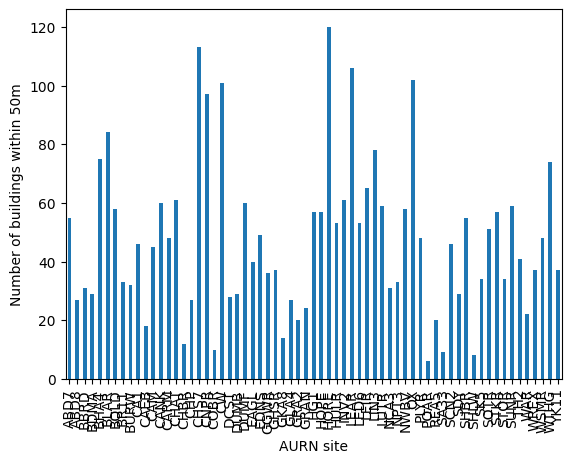

In [10]:
## group by AURN site and count the number of geometries - within 50m. Plot distribution with smaller labels
AURN_buildings.groupby('site').size().plot(kind='bar', ylabel='Number of buildings within 50m', xlabel='AURN site')

### Plot in 3D visualisation

In [11]:
import pydeck as pdk

subset_site = AURN_buildings_plot['site'].unique()[0]
met_day = 20
# Convert the coordinate system to WGS84
AURN_buildings_subset = AURN_buildings_plot[AURN_buildings_plot['site'] == subset_site]
AURN_buildings_subset = AURN_buildings_subset.to_crs(epsg=4326)
AURN_buildings_subset['lon'], AURN_buildings_subset['lat']= AURN_buildings_subset.geometry.centroid.x, AURN_buildings_subset.geometry.centroid.y

AURN_roads_subset = AURN_roads_plot[AURN_roads_plot['site'] == subset_site]
AURN_roads_subset = AURN_roads_subset.to_crs(epsg=4326)
## get start point of linestring in geometry column
AURN_roads_subset['start_lon'], AURN_roads_subset['start_lat'] = AURN_roads_subset.geometry.apply(lambda x: x.coords[0][0]), AURN_roads_subset.geometry.apply(lambda x: x.coords[0][1])
AURN_roads_subset['end_lon'], AURN_roads_subset['end_lat'] = AURN_roads_subset.geometry.apply(lambda x: x.coords[-1][0]), AURN_roads_subset.geometry.apply(lambda x: x.coords[-1][1])

AURN_met_subset = AURN_met[AURN_met['site_id'] == subset_site]

min_RelH2 = AURN_buildings_subset['RelH2'].min()
range_RelH2 = AURN_buildings_subset['RelH2'].max() - min_RelH2

AURN_met_gpd = gpd.GeoDataFrame(AURN_met_subset, geometry=gpd.points_from_xy(AURN_met_subset.longitude, AURN_met_subset.latitude))

AURN_buildings_subset['building_side_wind'] = AURN_buildings_subset['bearing_to_road'].apply(lambda x: building_side_wind(x, AURN_met_gpd['wdir'].iloc[met_day],AURN_roads_subset['road_orientation'].iloc[0]))
AURN_buildings_subset['building_side_road'] = AURN_buildings_subset['bearing_to_road'].apply(lambda x: building_side_road(x))

def get_color_from_RelH2(RelH2):
    normalized_RelH2 = (RelH2 - min_RelH2) / range_RelH2
    if normalized_RelH2 < 0.5:
        # Transition from green to yellow for the first half of the range
        return [normalized_RelH2 * 2 * 255, 255, 0]
    else:
        # Transition from yellow to red for the second half of the range
        return [255, 255 - ((normalized_RelH2 - 0.5) * 2 * 255), 0]

# Apply the function to the RelH2 column to get the colors
# AURN_buildings_subset['color'] = AURN_buildings_subset['RelH2'].apply(get_color_from_RelH2)

# get color from building_side_wind variable
def get_color_from_building_side_wind(building_side_wind):
    if building_side_wind == "windward":
        return [255, 0, 0]  # Red for windward
    elif building_side_wind == "leeward":
        return [0, 255, 0]  # Green for leeward

# Apply the function to the building_side_wind column to get the colors
AURN_buildings_subset['color'] = AURN_buildings_subset['building_side_wind'].apply(get_color_from_building_side_wind)

building_layer = pdk.Layer(
    "GeoJsonLayer",
    AURN_buildings_subset,
    opacity=1,
    stroked=True,
    filled=True,
    extruded=True,
    wireframe=True,
    get_elevation="RelH2",
    get_fill_color='color',
    get_line_color=[255, 60, 255],
    pickable=True,
)

road_layer = pdk.Layer(
    "LineLayer",
    AURN_roads_subset,
    get_source_position=['start_lon', 'start_lat'],
    get_target_position=['end_lon', 'end_lat'],
    opacity=1,
    stroked=True,
    filled=True,
    extruded=True,
    wireframe=True,
    get_width='roadwidth_average',
    get_color=[0, 0, 255],
    pickable=True
)

## create a marker layer for the AURN site
site_marker = pdk.Layer(
     "ScatterplotLayer",
    AURN_meta_ongoing[AURN_meta_ongoing['site_id'] == subset_site],
    get_position=['longitude', 'latitude'],
    get_fill_color=[255, 0, 0],
    get_line_color=[0, 0, 0],
    get_radius=2,
    extruded=True,
    get_elevation=20,
    pickable=True,
    auto_highlight=True,
    highlight_color=[255, 255, 0, 255],
)


# Extract wind direction and speed
wind_direction = AURN_met_gpd['wdir']  # replace with your column name
wind_speed = AURN_met_gpd['wspd']  # replace with your column name

# Convert wind speed to km/h
wind_speed_kmh = wind_speed / 3.6

## Convert wind direction from meteorological terms to mathematical terms
wind_direction_math = 360 + wind_direction

# Convert wind direction to radians
wind_direction_rad = np.deg2rad(wind_direction_math)

# Calculate end coordinates of the arrow based on wind direction and speed
# Divide wind_speed_kmh by a large number to bring the end coordinates closer to the original point
AURN_met_gpd['end_lon'] = AURN_met_gpd['longitude'] + np.sin(wind_direction_rad) * wind_speed_kmh / 10000
AURN_met_gpd['end_lat'] = AURN_met_gpd['latitude'] + np.cos(wind_direction_rad) * wind_speed_kmh / 10000

# Define a function to map wind speed to color
def get_color_from_speed(speed):
    if speed < 10:
        return [255, 0, 0]  # Red for speed < 10
    elif speed < 20:
        return [255, 255, 0]  # Yellow for 10 <= speed < 20
    else:
        return [0, 255, 0]  # Green for speed >= 20

# Apply the function to the wind_speed_kmh column to get the colors
AURN_met_gpd['color'] = AURN_met_gpd['wspd'].apply(get_color_from_speed)


# Create ArrowLayer
arrow_layer = pdk.Layer(
    "LineLayer",
    AURN_met_gpd.iloc[met_day:met_day+1],
    get_source_position=['longitude', 'latitude',50],
    get_target_position=['end_lon', 'end_lat',50],
    get_width=3,
    pickable=True,
    auto_highlight=True,
    get_color='color',
    opacity=0.5,
)

    
    # Set the viewport location
view_state = pdk.ViewState(
    longitude=AURN_buildings_subset.lon.mean(), latitude=AURN_buildings_subset.lat.mean(), zoom=17, min_zoom=5, max_zoom=20, pitch=0, bearing=0
)

# Combined all of it and render a viewport
r = pdk.Deck(
    layers=[building_layer,road_layer,arrow_layer,site_marker],
    initial_view_state=view_state,
    map_style="light",
)

r

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 57.144640328536795,
    "longitude": -2.1063062400209067,
    "maxZoom": 20,
    "minZoom": 5,
    "pitch": 0,
    "zoom": 17
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": [
        {
          "AbsH2": 46.5,
          "AbsHMax": 46.7,
          "AbsHMin": 26.0,
          "RelH2": 20.5,
          "RelHMax": 20.7,
          "Shape_Area": 2.6967,
          "Shape_Length": 7.40224248,
          "bearing_to_point": 249.74609587743726,
          "bearing_to_road": 269.3403460659673,
          "building_side_road": "west",
          "building_side_wind": "leeward",
          "color": [
            0,
            255,
            0
          ],
          "distance_to_point": 36.12010084426514,
          "geometry": {
            "coordinates": [
              [
                [
                  [
                    -2.107081681197056,
                    57.144577857891356
                  ],
                  [
                    -2.107096211318577,
                    57.14457371327115
                  ],
                  [
                    -2.1070756577861376,
                    57.144552171609575
                  ],
                  [
                    -2.10706096241987,
                    57.14455631636875
                  ],
                  [
                    -2.107081681197056,
                    57.144577857891356
                  ]
                ]
              ]
            ],
            "type": "MultiPolygon"
          },
          "lat": 57.14456499939894,
          "lon": -2.107078610799232,
          "site": "ABD7"
        },
        {
          "AbsH2": 33.7,
          "AbsHMax": 45.6,
          "AbsHMin": 25.4,
          "RelH2": 8.3,
          "RelHMax": 20.2,
          "Shape_Area": 852.509,
          "Shape_Length": 176.52788292,
          "bearing_to_point": 167.76266210524943,
          "bearing_to_road": 151.20192794978317,
          "building_side_road": "south",
          "building_side_wind": "windward",
          "color": [
            255,
            0,
            0
          ],
          "distance_to_point": 50.10320354036386,
          "geometry": {
            "coordinates": [
              [
                [
                  [
                    -2.106543003692339,
                    57.14373193746379
                  ],
                  [
                    -2.1065849476551977,
                    57.14377924226981
                  ],
                  [
                    -2.1065596849853927,
                    57.14378627053559
                  ],
                  [
                    -2.106469202039664,
                    57.14381158982266
                  ],
                  [
                    -2.106442948615797,
                    57.14381888839825
                  ],
                  [
                    -2.106423112441921,
                    57.1438166595108
                  ],
                  [
                    -2.1064223107580538,
                    57.143825194061556
                  ],
                  [
                    -2.10643470562277,
                    57.143825632673106
                  ],
                  [
                    -2.1064892500285874,
                    57.143887389457156
                  ],
                  [
                    -2.106477031251582,
                    57.1438907235696
                  ],
                  [
                    -2.106485319509419,
                    57.143899699538565
                  ],
                  [
                    -2.1064968778141395,
                    57.14389654564768
                  ],
                  [
                    -2.106521734856833,
                    57.143920778649566
                  ],
                  [
                    -2.1065093515997106,
                    57.143924382395724
                  ],
                  [
                    

# Processing

#### Add Canyon Factor

In [12]:
AURN_averagespeed.indicativespeedlimit_kph.iloc[0]

32

In [13]:
## for each row in the AURN_met dataframe,
output = pd.DataFrame()

for y in AURN_meta_ongoing['site_id'].unique():
    site_met = AURN_met[AURN_met['site_id']==y]
    site_met['canyon_factor'] = "N/A"
    site_met['windward_height_avg'] = "N/A"
    site_met['leeward_height_avg'] = "N/A"
    site_met['road_distance'] = "N/A"
    site_met['indicatedspeed_kph'] = "N/A"
    road = AURN_roads[AURN_roads['site']==y]
    buildings = AURN_buildings[AURN_buildings['site']==y]
    average_speed = AURN_averagespeed[AURN_averagespeed['site']==y]
    for met_day in range(0,len(site_met)):
        buildings['building_side_wind'] = buildings['bearing_to_road'].apply(lambda x: building_side_wind(x, site_met['wdir'].iloc[met_day],road['road_orientation'].iloc[0]))
        buildings['building_side_road'] = buildings['bearing_to_road'].apply(lambda x: building_side_road(x))
        cf = canyon_factor(buildings,road['road_orientation'].iloc[0],site_met['wdir'].iloc[met_day],site_met['wspd'].iloc[met_day])
        site_met['canyon_factor'].iloc[met_day] = cf
        site_met['windward_height_avg'].iloc[met_day] = buildings[buildings['building_side_wind']=="windward"]['RelH2'].mean()
        site_met['leeward_height_avg'].iloc[met_day] = buildings[buildings['building_side_wind']=="leeward"]['RelH2'].mean()
        site_met['road_distance'].iloc[met_day] = road['distance_to_point'].iloc[0]
        site_met['indicatedspeed_kph'].iloc[met_day] = average_speed['indicativespeedlimit_kph'].iloc[0]
    output = pd.concat([output,site_met])



# Generate a finalised data table for output

In [14]:
output.head()


tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
2024-01-01   0.7  -2.2   5.7   1.5   NaN    2.0   2.0  10.0   991.5   NaN   
2024-01-02   6.5  -2.2   9.4   0.8   NaN  116.0  18.2  57.0   982.1   NaN   
2024-01-03   5.6   4.7   7.5  19.0   NaN  131.0  23.2  53.0   986.6   NaN   
2024-01-04   6.4   5.1   8.1  16.5   NaN  161.0  15.5  49.0   995.7   NaN   
2024-01-05   4.4  -0.7   6.8   1.8   NaN  232.0   4.6  22.0  1002.6   NaN   

           site_id   latitude  longitude  elevation canyon_factor  \
2024-01-01    ABD7  57.144555  -2.106472      25.66           2.0   
2024-01-02    ABD7  57.144555  -2.106472      25.66          36.4   
2024-01-03    ABD7  57.144555  -2.106472      25.66          46.4   
2024-01-04    ABD7  57.144555  -2.106472      25.66          31.0   
2024-01-05    ABD7  57.144555  -2.106472      25.66           9.2   

           windward_height_avg leeward_height_avg road_distance  \
2024-01-01            8.962069           7.796154     15.215526   
2024-01-02            7.796154           8.962069     15.215526   
2024-01-03            7.796154           8.962069     15.215526   
2024-01-04            7.796154           8.962069     15.215526   
2024-01-05            7.796154           8.962069     15.215526   

           indicatedspeed_kph  
2024-01-01                 32  
2024-01-02                 32  
2024-01-03                 32  
2024-01-04                 32  
2024-01-05                 32